# Environment Setting


## Install and Import libraries

In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409501 sha256=c5b51404f160d45d5a3349adb7cb4db9aa479e9e54c6fb123267894326f5a6a4
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [1]:
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
from gymnasium.utils.env_checker import check_env
from collections import defaultdict
import numpy as np
from tqdm import tqdm  # Progress bar
from matplotlib import pyplot as plt
from typing import Optional
from gymnasium import spaces
import matplotlib.pyplot as plt
seed = 1310

## Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # do this once per session

Mounted at /content/drive


## git

In [ ]:
!git add
!git commit -m "msg"
!git push origin branch

fatal: not a git repository (or any of the parent directories): .git


if a file is new or has been modified and the changes haven't been added to the Git repo yet, do the following

In [ ]:
!git clone https://github.com/MonashDeepNeuron/Rummikub-Simulation-with-RL.git



Cloning into 'Rummikub-Simulation-with-RL'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), done.


In [ ]:
%cd Rummikub-Simulation-with-RL

/content/Rummikub-Simulation-with-RL/Rummikub-Simulation-with-RL


In [ ]:
!git checkout Maze-game


Branch 'Maze-game' set up to track remote branch 'Maze-game' from 'origin'.
Switched to a new branch 'Maze-game'


# First trial

## Environment

In [2]:
env_row = 5
env_column = 5


In [3]:
'''
# define the action
up = 0
down = 1
left = 2
right = 3
'''
actions = ["up", "down", "left", "right"]

q_values = np.zeros((env_row, env_column, len(actions))) # we have 5rows, 5columns, and 4 actions

In [4]:
reward_matrix = np.full((env_row, env_column), -1)
reward_matrix[-1, -1] = 100 # the reward of the goal is 100
for rows in reward_matrix:
  print(rows)

[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[ -1  -1  -1  -1 100]


In [5]:
# to see if the specified location is a terminal state
# def is_terminal_state(current_row_index, current_column_index):
#   if reward[current_row_index, current_column_index] == -100:
#     return False
#   else:
#     return True
def is_terminal_state(current_row_index, current_column_index):
    return (current_row_index == env_row - 1) and (current_column_index == env_column - 1)


# starting location
def get_starting_location():
  return 0, 0

# Get next action - epsilon greedy algo
# if a randomly chosen value, which is between 0 and 1, is < epsilon
# then choose the most promising value from Q-table for this state
def get_next_action(current_row_index, current_column_index, epsilon):
    if np.random.random() < epsilon:
        # Exploration – pick a random action
        return np.random.randint(4)
    else:
        # Exploitation – pick best action
        return np.argmax(q_values[current_row_index, current_column_index])


In [6]:
#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
    new_row_index, new_column_index = current_row_index, current_column_index

    if actions[action_index] == 'up' and current_row_index > 0:
        new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < env_column - 1:
        new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < env_row - 1:
        new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
        new_column_index -= 1

    return new_row_index, new_column_index


In [7]:
#Define a function that will get the shortest path between any location within the maze that
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index):
  #return immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index):
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the bottom right corner)
    while not is_terminal_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    return shortest_path

## Agent

In [8]:
#define training parameters
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.9 #the rate at which the AI agent should learn

#run through 1000 training episodes
for episode in range(1000):
  #get the starting location for this episode
  row_index, column_index = get_starting_location()

  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
  while not is_terminal_state(row_index, column_index):
    #choose which action to take (i.e., where to move next)
    action_index = get_next_action(row_index, column_index, epsilon)

    #perform the chosen action, and transition to the next state (i.e., move to the next location)
    old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
    row_index, column_index = get_next_location(row_index, column_index, action_index)

    #receive the reward for moving to the new state, and calculate the temporal difference
    reward = reward_matrix[row_index, column_index]
    old_q_value = q_values[old_row_index, old_column_index, action_index]
    temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

    #update the Q-value for the previous state and action pair
    new_q_value = old_q_value + (learning_rate * temporal_difference)
    q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Training complete!')

Training complete!


In [9]:
#display a few shortest paths
print(get_shortest_path(3, 3)) #starting at row 3, column 9
print(get_shortest_path(2, 0)) #starting at row 5, column 0
print(get_shortest_path(4, 1)) #starting at row 9, column 5

[[3, 3], [3, 2], [2, 2], [1, 2], [0, 2], [1, 2], [2, 2], [2, 3], [3, 3], [4, 3], [3, 3], [3, 2], [4, 2], [4, 1], [4, 0], [4, 0], [4, 0], [4, 1], [3, 1], [4, 1], [3, 1], [3, 2], [4, 2], [3, 2], [3, 3], [3, 2], [3, 3], [4, 3], [4, 2], [4, 1], [3, 1], [2, 1], [2, 0], [1, 0], [0, 0], [0, 1], [0, 1], [0, 2], [0, 1], [0, 1], [1, 1], [1, 0], [1, 0], [1, 1], [1, 0], [1, 1], [1, 0], [2, 0], [3, 0], [2, 0], [3, 0], [4, 0], [3, 0], [4, 0], [4, 1], [4, 2], [3, 2], [3, 1], [3, 0], [3, 0], [2, 0], [2, 1], [1, 1], [2, 1], [3, 1], [3, 2], [3, 3], [3, 4], [3, 3], [2, 3], [3, 3], [2, 3], [2, 2], [2, 3], [2, 4], [2, 4], [1, 4], [2, 4], [3, 4], [2, 4], [3, 4], [3, 4], [3, 3], [2, 3], [3, 3], [4, 3], [4, 4]]
[[2, 0], [2, 0], [2, 1], [2, 2], [3, 2], [3, 1], [2, 1], [3, 1], [3, 2], [3, 3], [4, 3], [4, 2], [3, 2], [3, 3], [3, 4], [2, 4], [2, 4], [3, 4], [4, 4]]
[[4, 1], [4, 2], [4, 1], [4, 1], [4, 1], [4, 2], [3, 2], [3, 3], [3, 4], [4, 4]]


In [10]:
#display an example of reversed shortest path
path = get_shortest_path(4, 2) #go to row 5, column 2
path.reverse()
print(path)

[[4, 4], [4, 3], [4, 2]]


# Second trial

## Environment 2

In [11]:
class MazeEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, render_mode: str = None):
        super(MazeEnv, self).__init__()

        # Define 5x5 grid
        self.grid_size = 5
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size])
        self.action_space = spaces.Discrete(4)  # up, down, left, right

        self.actions = ["up", "down", "left", "right"]
        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]

        # Rewards
        self.reward_matrix = np.full((self.grid_size, self.grid_size), -1)
        self.reward_matrix[self.goal_pos[0], self.goal_pos[1]] = 100
        self.render_mode = render_mode

    def _is_within_bounds(self, row, col):
      return 0 <= row < self.grid_size and 0 <= col < self.grid_size

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = [0, 0] # Set the player back to the top-left corner
        return np.array(self.agent_pos, dtype=int), {}
        # return the starting state of the env
        # also return Optional metadata.
          #It can include debug information or anything extra the environment wants to expose

    def step(self, action):
        row, col = self.agent_pos

        if action == 0 and row > 0:  # up
            row -= 1
        elif action == 1 and row < self.grid_size - 1:  # down
            row += 1
        elif action == 2 and col > 0:  # left
            col -= 1
        elif action == 3 and col < self.grid_size - 1:  # right
            col += 1

        if self._is_within_bounds(row, col):
            self.agent_pos = [row, col]

        reward = self.reward_matrix[self.agent_pos[0], self.agent_pos[1]]
        done = (self.agent_pos == self.goal_pos)

        return np.array(self.agent_pos, dtype=int), reward, done, False, {}

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), "⬜")
        grid[self.goal_pos[0], self.goal_pos[1]] = "🏁"
        grid[self.agent_pos[0], self.agent_pos[1]] = "🤖"
        for row in grid:
            print(" ".join(row))
        print("\n")

## Q-Learning

**Temporal Difference** \
`td` stands for Temporal Difference error. \
* It measures how surprised the agent is by what just happened.\
$$TD=[\text{What I got}]+[\text{Future prediction}]−[\text{What I expected}]$$

`gamma` is a **Discount Factor**
* between 0 and 1
* It controls how much the agent cares about future rewards vs. immediate rewards
* the closer to 0, the more it cares about immediate reward\

\
`alpha` is the **learning rate**

In [12]:
# --- Q-Learning ---
def train_q_learning(env, episodes=1000, epsilon=0.9, alpha=0.9, gamma=0.9):
    q_table = np.zeros((env.grid_size, env.grid_size, env.action_space.n))
    rewards_per_episode = []
    first_path = []
    last_path = []

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        path = [state.tolist()]

        while not done:
            row, col = state
            if np.random.random() < epsilon:
                action = np.random.randint(4)
            else:
                action = np.argmax(q_table[row, col])

            next_state, reward, done, _, _ = env.step(action)

            next_row, next_col = next_state
            old_q = q_table[row, col, action]
            td = reward + gamma * np.max(q_table[next_row, next_col]) - old_q
            q_table[row, col, action] = old_q + alpha * td

            state = next_state
            path.append(state.tolist())
            total_reward += reward

        if ep == 0:
            first_path = path.copy()
        if ep == episodes - 1:
            last_path = path.copy()

        rewards_per_episode.append(total_reward)

    return q_table, rewards_per_episode, first_path, last_path

## Visualization

In [13]:
# --- Visualization ---
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.grid(True)
    plt.show()

def print_path_comparison(first_path, last_path):
    print("First Episode Path:")
    print(" -> ".join([f"{p}" for p in first_path]))
    print("\nLast Episode Path:")
    print(" -> ".join([f"{p}" for p in last_path]))

## Run Everything

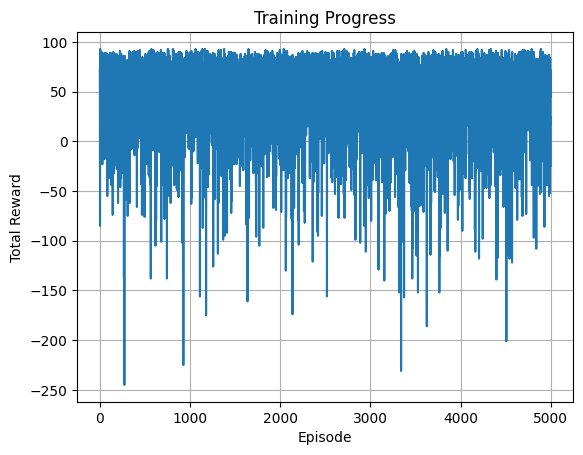

First Episode Path:
[0, 0] -> [1, 0] -> [1, 1] -> [1, 2] -> [2, 2] -> [3, 2] -> [3, 1] -> [4, 1] -> [4, 2] -> [4, 3] -> [3, 3] -> [4, 3] -> [4, 3] -> [4, 2] -> [3, 2] -> [2, 2] -> [1, 2] -> [2, 2] -> [3, 2] -> [4, 2] -> [4, 1] -> [4, 2] -> [4, 3] -> [4, 3] -> [4, 2] -> [4, 2] -> [3, 2] -> [4, 2] -> [4, 3] -> [4, 4]

Last Episode Path:
[0, 0] -> [0, 0] -> [0, 0] -> [0, 0] -> [0, 0] -> [0, 0] -> [0, 1] -> [0, 1] -> [1, 1] -> [1, 2] -> [0, 2] -> [1, 2] -> [0, 2] -> [0, 1] -> [1, 1] -> [2, 1] -> [3, 1] -> [4, 1] -> [4, 2] -> [4, 1] -> [4, 0] -> [4, 0] -> [4, 0] -> [3, 0] -> [3, 1] -> [4, 1] -> [4, 0] -> [4, 1] -> [4, 0] -> [3, 0] -> [3, 0] -> [4, 0] -> [4, 1] -> [3, 1] -> [3, 0] -> [4, 0] -> [3, 0] -> [2, 0] -> [2, 1] -> [3, 1] -> [2, 1] -> [2, 0] -> [2, 1] -> [2, 2] -> [2, 3] -> [1, 3] -> [0, 3] -> [0, 4] -> [0, 4] -> [0, 4] -> [0, 4] -> [0, 4] -> [0, 4] -> [0, 4] -> [1, 4] -> [0, 4] -> [1, 4] -> [1, 4] -> [1, 3] -> [1, 4] -> [2, 4] -> [2, 4] -> [2, 3] -> [1, 3] -> [2, 3] -> [2, 4] -> [2,

In [14]:
if __name__ == "__main__":
    env = MazeEnv()  # No need for gym.make() since it's a custom env
    q_table, rewards, first_path, last_path = train_q_learning(env, episodes=5000)
    plot_rewards(rewards)
    print_path_comparison(first_path, last_path)

    # Show shortest path from start
    state, _ = env.reset()
    done = False
    env.render()
    while not done:
        row, col = state
        action = np.argmax(q_table[row, col])
        state, _, done, _, _ = env.step(action)
        env.render()

# End of editing the file

In [ ]:
!ls -al Rummikub-Simulation-with-RL

ls: cannot access 'Rummikub-Simulation-with-RL': No such file or directory


In [ ]:
!pwd

/content/Rummikub-Simulation-with-RL/Rummikub-Simulation-with-RL


In [ ]:
!mv Maze-Charis.ipynb Rummikub-Simulation-with-RL/

mv: cannot stat 'Maze-Charis.ipynb': No such file or directory


In [ ]:
!git add Maze-Charis.ipynb

fatal: pathspec 'Maze-Charis.ipynb' did not match any files


In [ ]:
!git commit -m "Add Maze-Charis.ipynb for maze game environment"

In [ ]:
!git push origin Maze-game